# Financial Inclusion in Africa


The data for this project is gotten the "Financial Inclusion in Africa" Competition on Zindi.

###### Tasks:
- Data ingestion
- Data preprocessing
- Train and evaluate a base model
- Improve the model (if necessary)
- Deploy the model in backend server (accessible via a REST API)

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warning messages (if any)
import warnings
warnings.filterwarnings('ignore')

# Always display plots in this notebook
# %matplotlib inline


# Set theme for seaborn plots

# sns.set_style(style = 'whitegrid')
# sns.set_style('darkgrid')
sns.set_theme(style="darkgrid", font_scale=1.3)

## Data ingestion

In [12]:
# Load the dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_sub = pd.read_csv('data/SampleSubmission.csv')

In [13]:
# See the shape of the datasets
print("Rows & columns in train data", train.shape)
print("Rows & columns in test data", test.shape)

Rows & columns in train data (16466, 13)
Rows & columns in test data (7058, 13)


In [9]:
# train['bank_account'].value_counts()

In [10]:
# test['bank_account'].value_counts()

# Data preprocessing

### Data Transformation

###### Convert the year column to a object(string) datatype

In [87]:
train['year'] = train['year'].astype('object')
test['year'] = test['year'].astype('object')

###### Log transform the "age_of_respondent" and "household_size" features

In [14]:
train[['log_household_size', 'log_age_of_respondent']] = np.log(train[['household_size', 'age_of_respondent']])
test[['log_household_size', 'log_age_of_respondent']] = np.log(test[['household_size', 'age_of_respondent']])

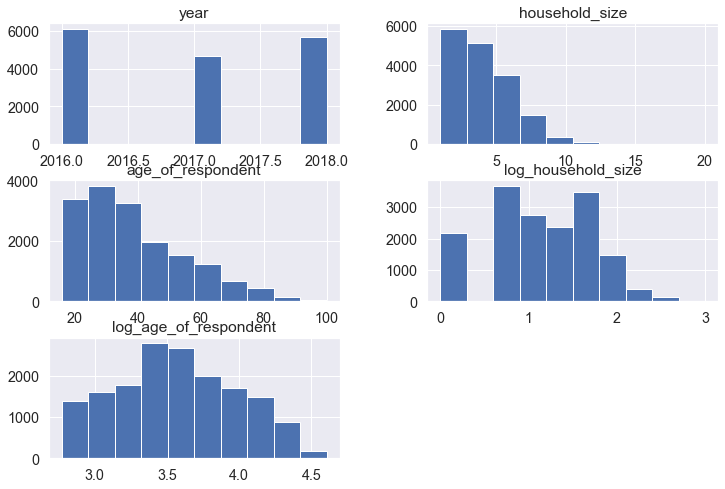

In [15]:
train.hist(figsize=(12, 8))
plt.show()

### Data Cleaning

###### Drop values like "Dont know" in categorical features that appear insignificant to predicting bank account ownership

In [90]:
# Remove instances with "Dont know" in "marital status" feature
train.drop(train[train['marital_status'] == 'Dont know'].index, inplace=True)

In [91]:
# Remove instances with "Other/Dont know/RTA" in "education level" feature
train.drop(train[train['education_level'] == 'Other/Dont know/RTA'].index, inplace=True)

In [92]:
# Remove instances with "Dont Know/Refuse to answer" in "job type" feature
train.drop(train[train['job_type'] == 'Dont Know/Refuse to answer'].index, inplace=True)

###### Treat outliers

In [93]:
#  Function to find and drop outliers
def find_outliers(df, drop=False, exclude = []):
    '''
    Returns and optionally drops rows/instances with outliers in continuous/numeric 
    features from the provided dataframe(df)

    
    df: data in a dataframe
    drop: remove/drop outlier instances
    exclude: list of feature(s) whose outliers should be left
    
    
    '''
    
    outliers_indexes = set()
    
    # Get names of the Continuous features
    num_columns = df.select_dtypes(include='number').columns
    

    for col in num_columns:
        
        if (exclude != []) & (col in exclude):
            pass
        
        else:
            
            feature = df[col]

            # Compute the first and third quantiles and IQR of the feature
            q1 = np.quantile(feature, 0.25)
            q3 = np.quantile(feature, 0.75)
            iqr = q3 - q1

            # Calculate the lower and upper cutoffs for outliers
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            # Subset feature to find outliers
            outliers = feature[(feature < lower) | (feature > upper)]
            
            # Update list of unique outliers             
            outliers_indexes.update(outliers.index)

            print(f"Total outliers for {col} is {len(outliers)} at {round((len(outliers) / len(df) * 100), 2)}%")
            # print(outliers.index)
            
            
    if drop:
        df.drop(index=outliers_indexes, inplace=True)
        print(f"Removed {len(outliers_indexes)} rows/instance(s)")
        

In [94]:
# Find outlier instances
find_outliers(train)

Total outliers for household_size is 374 at 1.6%
Total outliers for age_of_respondent is 237 at 1.01%
Total outliers for log_household_size is 2 at 0.01%
Total outliers for log_age_of_respondent is 0 at 0.0%


In [95]:
# Drop the outlier instances
find_outliers(train, drop=True, exclude = ["household_size", "age_of_respondent"])

Total outliers for log_household_size is 2 at 0.01%
Total outliers for log_age_of_respondent is 0 at 0.0%
Removed 2 rows/instance(s)


###### Insight:
Taking the log of "household_size" and "age_of_respondent" helped deal with all but **2 outliers in "household_size**

In [96]:
train.shape

(23353, 15)

In [97]:
# train.columns

In [98]:
# train['job_type'].value_counts()

In [99]:
# train['education_level'].count()

### Feature Engineering

In [100]:
# Get names of the Categorical and Continuous features
cat_columns = train.select_dtypes(exclude='number').columns
num_columns = train.select_dtypes(include='number').columns

In [101]:
# # Generate age groups from the "age of respondent" feature

# bins = [16,31,49,60,125]
# labels = ["Young Adult","Middle Aged","Old Adult","Elderly"]
# data["age_group"] = pd.cut(data["age_of_respondent"], bins = bins ,labels = labels, right = False)

### Data Splitting

In [102]:
# Import library
from sklearn.model_selection import train_test_split

In [103]:
# Define the input features and target 

col_to_drop = ['uniqueid', 'country', 'year', 'bank_account', 'household_size', 'age_of_respondent']

X = train.drop(columns = col_to_drop)
y = train['bank_account']

In [104]:
X.sample(1)

,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,log_household_size,log_age_of_respondent
7292,Rural,Yes,Male,Head of Household,Married/Living together,No formal education,Informally employed,1.098612,3.135494


###### Split the data

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

### Feature Scaling

In [106]:
# Import necessary libraries

from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

In [107]:
# Initialize scaler instance
input_scaler = StandardScaler()
# input_scaler = MinMaxScaler() 

In [108]:
# Numerical features(columns) in the dataset
numerical = X.select_dtypes(include="number").columns

num_exists = numerical.empty == False

# Scale numerical features if they exist in dataset
if (num_exists):
    X_train[numerical] = input_scaler.fit_transform(X_train[numerical])
    X_test[numerical] = input_scaler.transform(X_test[numerical])

In [109]:
# X_train.sample()

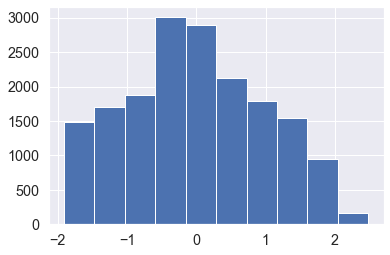

In [110]:
# See distribution
X_train["log_age_of_respondent"].hist()
plt.show()

### Feature Encoding

In [111]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [112]:
# Initialize encoder instance, ignore unknown categories, don't return a sparse matrix
cat_encoder = OneHotEncoder(dtype=np.int, handle_unknown='ignore', sparse_output=False)

###### Encode input features

In [113]:
# Categorical features
# categorical = X.select_dtypes(include="category").columns
categorical = X.select_dtypes(include="object").columns

cat_exists = categorical.empty == False


# Encode categorical features if they exist in dataset
if (cat_exists):
    
    # Encode the categorical features(columns) and generate appropriate column names
    cat_train_df = pd.DataFrame(cat_encoder.fit_transform(X_train[categorical]), index=X_train.index)
    cat_test_df = pd.DataFrame(cat_encoder.transform(X_test[categorical]), index=X_test.index)

    cat_train_df.columns = cat_encoder.get_feature_names_out(categorical)
    cat_test_df.columns = cat_encoder.get_feature_names_out(categorical)
    
    # cat_train_df.columns
    
    # Join the new dataframe to our original data then drop the categorical columns
    X_train = X_train.join(cat_train_df).drop(columns = categorical)
    X_test = X_test.join(cat_test_df).drop(columns = categorical)

In [114]:
# X_train.shape

In [115]:
X_train.sample()

,log_household_size,log_age_of_respondent,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male,relationship_with_head_Child,relationship_with_head_Head of Household,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
1806,-0.726441,1.626042,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


###### Encode the target feature

In [116]:
# Initialize encoder instance
target_enc = LabelEncoder()

In [117]:
# Fit and transform the target
target_enc.fit(y_train)

y_train = target_enc.transform(y_train)

y_test = target_enc.transform(y_test)

In [118]:
target_enc.inverse_transform([0,1])

array(['No', 'Yes'], dtype=object)

### Feature Importance

In [119]:
# Import necessary libraries
from sklearn.feature_selection import RFE, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [145]:
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif)
#     fs = SelectKBest(score_func=chi2)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)


# What are scores for the features
# for i in range(len(fs.scores_)):
#  print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
# plt.figure(figsize=(20, 10))
# plt.barh([i for i in range(len(fs.scores_))], fs.scores_)
# plt.yticks([i for i in range(len(fs.scores_))], labels=fs.feature_names_in_)
# plt.grid(b=None)
# plt.title("Feature Importance")
# plt.show()

In [146]:
X_train_fs[0]

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [147]:
# feat = pd.DataFrame(fs.scores_, index=fs.feature_names_in_)

imp_data = {'Feature' : fs.feature_names_in_, 'Score': fs.scores_}

feat_scores = pd.DataFrame( data = imp_data)

In [148]:
# feat.sort_values(by='Score', ascending=False).head(10).plot.barh()

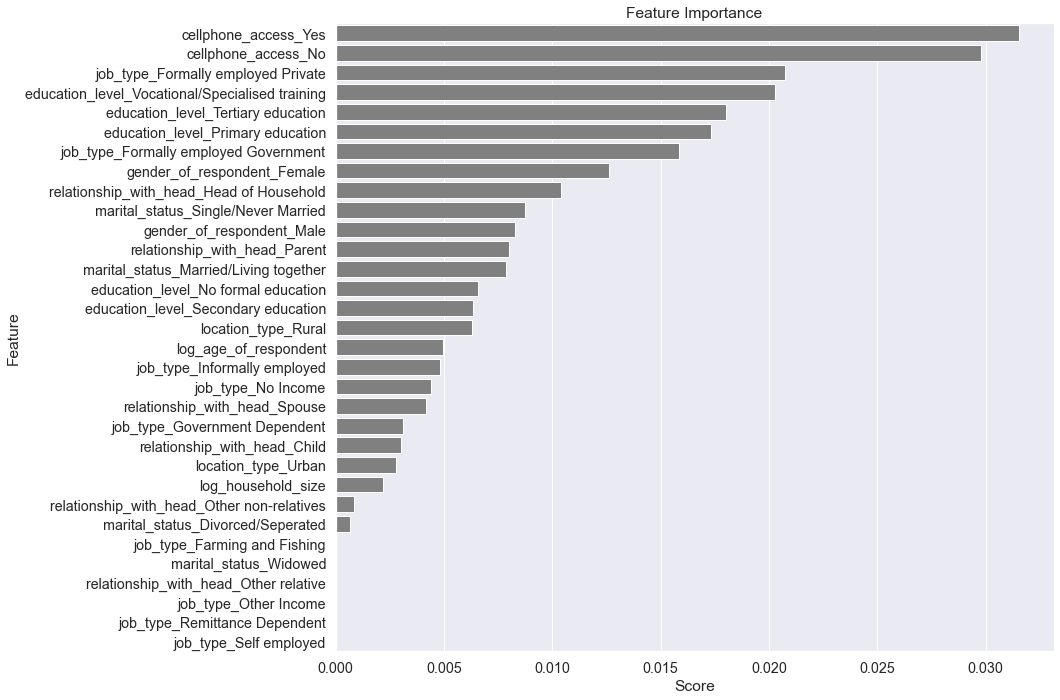

In [149]:
fig, ax = plt.subplots(figsize=(15, 10))
        
ax.set_title("Feature Importance")
sns.barplot(data = feat_scores.sort_values(by='Score', ascending=False), x="Score", y="Feature", ax=ax, color="grey", orient="h")
    
fig.tight_layout()  
plt.show()

# Train and evaluate a base model

Evaluation metrics to use
1. **AUC - ROC Curve (AUROC)**: AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.
2. **Matthews correlation coefficient (MCC) over F1 Score**: The MCC has two advantages over the F1-score. 
- F1 varies for class swapping, while MCC is invariant if the positive class is renamed negative and vice versa.
- F1 is independent from the number of samples correctly classified as negative.    
[thedatascientist.com](https://thedatascientist.com/metrics-matthews-correlation-coefficient/)

In [2]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import matthews_corrcoef

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Evaluate model using classification report
def modelEval(model):
    model.fit(X_train, y_train)
#     model.fit(X_train_fs, y_train)

    accuracy = model.score(X_test, y_test)
#     accuracy = model.score(X_test_fs, y_test)
    
    y_pred = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)[:, 1]
#     y_pred = model.predict(X_test_fs)
#     y_prob_test = model.predict_proba(X_test_fs)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test > 0.4)
    
    df = pd.DataFrame({
        'Precision': precision, 
        'Recall' : recall
#         'Thresholds' : thresholds + [0]
    })
#     print(df.head(5))

    
    print("*** MODEL EVALUATION REPORT *** \n")
    print("AUC_ROC Score", roc_auc_score(y_test, y_prob_test))
    print("F1 Score", f1_score(y_test, y_pred))
    print("MCC", matthews_corrcoef(y_test, y_pred))
    print("MAE", mean_absolute_error(y_test, y_pred))
    print("Mean Accuracy: ", accuracy)
    print(classification_report(y_test, y_pred))
    print('\n')



In [ ]:
# Evaluate model
def evaluate_model(actual, predicted, probability):
    
    auc = roc_auc_score(actual, probability)
    f1  = f1_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mcc = matthews_corrcoef(actual, predicted)        
    
    return auc, f1, mae, mcc

    
def display_plots(actual, predicted):  

    # Display the Confusion Matrix
    cm = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)

    cm_display.plot()
    plt.title("Confusion Matrix")
    plt.show()
    
    
    # Plot the Precision-Recall Curve
    # display = PrecisionRecallDisplay.from_estimator(model, actual, predicted, name="Avg Precision", )
    display = PrecisionRecallDisplay.from_predictions(actual, predicted, name="Avg Precision")
    
    _ = display.ax_.set_title("Precision-Recall curve")
    plt.show()

    print('\n')

In [72]:
# Base models for experiment
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGB": XGBClassifier(), 
    "GaussianNB": GaussianNB()
}

###### Model training and evaluation

In [81]:
# Train model

def train_model(model, X_train, y_train, X_test, y_test, show_plots=False):
    # List(s) of performance metrics     
    accuracy_scores = []
    auc_scores = []
    f1_scores  = []
    mae_scores = []
    mcc_scores = []


    for model in list(models.values()):
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        accuracy = model.score(X_test, y_test)

        # Get evaluation metrics  
        auc, f1, mae, mcc = evaluate_model(y_test, y_pred, y_prob)

        # Add metrics to respective list
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        f1_scores.append(f1)
        mae_scores.append(mae)
        mcc_scores.append(mcc)

        # Plot     
        if show_plots:
            display_plots(y_test, y_pred)

    # Create a Report "Table"    
    eval_report = pd.DataFrame({
        'Model Name': list(models.keys()),
        # 'Accuracy': accuracy_scores, 
        'AUC_ROC' : auc_scores,
        'F1': f1_scores, 
        # 'MAE' : mae_scores,
        'MCC': mcc_scores
    })
    
    return eval_report

# PLAY AREA

In [1]:
%pwd

'C:\\Users\\Ihekamadu\\Desktop\\DS-ML-AI-Stuff\\Projects\\predict-financial-inclusion-africa\\notebook'

In [65]:
def display_plots(model, actual, predicted):  

    # Display the Confusion Matrix
    cm = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)

    cm_display.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [63]:
def evaluate_models(models: dict, show_plots: bool=False):

    # List(s) of performance metrics     
    accuracy_scores: list = []
    auc_scores: list = []
    f1_scores: list = []
    mcc_scores: list = []

    model_names = list(models.keys())
    model_list = list(models.values())


    for model in model_list:

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Get evaluation metrics
        accuracy_scores.append(model.score(X_test, y_test))
        auc_scores.append(roc_auc_score(y_test, y_prob))
        f1_scores.append(f1_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))


        # Display evaluation plot(s)
        if show_plots:
            display_plots(model, y_test, y_pred)


    # Create a Report "Table"    
    evaluation_report = pd.DataFrame({
        'Model Name': model_names,
        'Accuracy': accuracy_scores,
        'AUC_ROC' : auc_scores,
        'F1': f1_scores, 
        'MCC': mcc_scores
    })

    return evaluation_report


In [60]:
def train(save_best_model: bool = False, save_report: bool = False, show_plots: bool = False, report_title: str = ""):

    evaluation_report = evaluate_models(models, show_plots=show_plots)


    if save_report:
        file_name = report_title or "base_model_report"

        # Save report as CSV file (on disk)
        evaluation_report.to_csv(f"{file_name}.csv", index=False)


    if save_best_model:
        evaluation

In [115]:
evaluation_report = evaluate_models(models)

In [116]:
evaluation_report

,Model Name,Accuracy,AUC_ROC,F1,MCC
0,Logistic Regression,0.886962,0.843257,0.438298,0.428972
1,K-Neighbors,0.876472,0.778303,0.459231,0.407663
2,GaussianNB,0.835367,0.833925,0.511746,0.424410


In [122]:
# evaluation_report.sort_values('MCC')['MCC'].max()
index = evaluation_report[evaluation_report['MCC'] == evaluation_report['MCC'].max()].index
index[0]
# best_model = model_list[index[0]]

0

In [140]:
[name, acc, auc, f1, mcc] = evaluation_report[evaluation_report['MCC'] == evaluation_report['MCC'].max()].values[0]
name, acc
# models[name]

('Logistic Regression', 0.8869621066152859)

In [175]:
# evaluation_report.sort_values(['F1', 'MCC'], ascending=False).head(1).values[0]
# evaluation_report.sort_values(['F1', 'MCC'], ascending=False)
# evaluation_report.sort_values(['MCC', 'AUC_ROC', 'F1', 'Accuracy'], ascending=False).head(1).index[0]
evaluation_report = evaluation_report.sort_values(['MCC', 'AUC_ROC', 'F1', 'Accuracy'], ascending=False)

In [182]:
c = evaluation_report.head(1).values[0]

In [188]:
log_msg = f"Saved model:{c[0]} with performance: Accuracy - {c[1]}, AUC_ROC - {c[2]}, F1 - {c[3]},  MCC - {c[4]}"

print(log_msg)

Saved model:Logistic Regression with performance: Accuracy - 0.8869621066152859, AUC_ROC - 0.843256934064109, F1 - 0.4382978723404255,  MCC - 0.4289719478258027


In [186]:
data_dir = "../artifacts/processed"

# Get and save clean train/test datasets as instance attribute
X_train = pd.read_csv("../artifacts/processed/X_train.csv")
X_test = pd.read_csv("../artifacts/processed/X_test.csv")
y_train = pd.read_csv("../artifacts/processed/y_train.csv")
y_test = pd.read_csv("../artifacts/processed/y_test.csv")

models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors": KNeighborsClassifier(),
    # "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier(),
    # "XGB": XGBClassifier(), 
    "GaussianNB": GaussianNB()
}

In [19]:
from pickle import dump, load

In [32]:
def load_object(file_path):
    
    # load the object/file
    # file = open(file_path, "rb")

    # return load(file)

    with open(file_path, 'rb') as file:
        return load(file)

#     return file

In [113]:
le = load_object("../artifacts/label_encoder.pkl")
ps = load_object("../artifacts/preprocessor.pkl")

In [114]:
X_train = ps.transform(X_train)
X_test = ps.transform(X_test)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

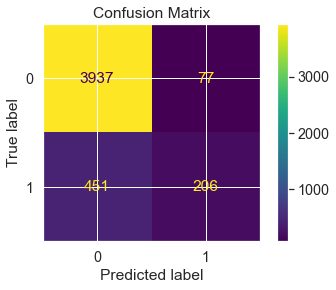

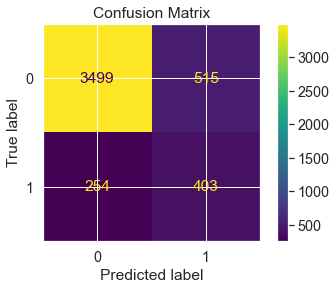

PermissionError: [Errno 13] Permission denied: 'base_model_report.csv'

In [66]:
train(save_best_model=False, save_report=True, show_plots=True)

# PLAY AREA END

In [128]:
train_model(model, X_train_fs, y_train, X_test_fs, y_test)

[17:37:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy,AUC_ROC,F1,MAE,MCC
0,Logistic Regression,0.881658,0.833181,0.418839,0.118342,0.399923
1,K-Neighbors,0.879089,0.770253,0.415563,0.120911,0.389331
2,Decision Tree,0.885426,0.831444,0.425751,0.114574,0.417703
3,Random Forest,0.884569,0.831631,0.424915,0.115431,0.413813
4,XGB,0.885083,0.833470,0.424034,0.114917,0.415610
5,GaussianNB,0.865559,0.819807,0.474916,0.134441,0.401233


In [133]:
train_model(model, X_train_fs, y_train, X_test_fs, y_test)

[18:31:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy,AUC_ROC,F1,MAE,MCC
0,Logistic Regression,0.886282,0.840506,0.456628,0.113718,0.433678
1,K-Neighbors,0.877205,0.756115,0.471629,0.122795,0.417424
2,Decision Tree,0.853742,0.662354,0.388252,0.146258,0.314419
3,Random Forest,0.864874,0.777525,0.427846,0.135126,0.362884
4,XGB,0.883370,0.835663,0.468384,0.116630,0.430361
5,GaussianNB,0.859051,0.825644,0.495402,0.140949,0.413504


In [150]:
train_model(model, X_train_fs, y_train, X_test_fs, y_test)

[00:42:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy,AUC_ROC,F1,MAE,MCC
0,Logistic Regression,0.883884,0.800875,0.396797,0.116116,0.400691
1,K-Neighbors,0.867272,0.751854,0.400619,0.132728,0.348175
2,Decision Tree,0.883370,0.808333,0.412425,0.116630,0.403957
3,Random Forest,0.883028,0.808333,0.409680,0.116972,0.401447
4,XGB,0.881658,0.807154,0.410912,0.118342,0.396412
5,GaussianNB,0.865559,0.802019,0.474916,0.134441,0.401233


## Improve the model (if necessary)


In [135]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# from sklearn.linear_model import SGDClassifier

import scipy.stats as stats
from sklearn.utils.fixes import loguniform


# import packages for random oversampling training data
# from numpy import mean

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

In [142]:
# Create an oversampler for the minority class

# over_sampler = RandomOverSampler( random_state=42)
# over_sampler = SMOTETomek(random_state=42)
over_sampler = SMOTE(sampling_strategy='minority', random_state=42)

# # fit and apply the transform
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train_fs, y_train)

In [140]:
train_model(model, X_train_sampled, y_train_sampled, X_test, y_test)

[18:38:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy,AUC_ROC,F1,MAE,MCC
0,Logistic Regression,0.809214,0.838112,0.488522,0.190786,0.397998
1,K-Neighbors,0.791060,0.780804,0.457295,0.208940,0.359259
2,Decision Tree,0.828567,0.668270,0.410830,0.171433,0.310891
3,Random Forest,0.837301,0.802440,0.458381,0.162699,0.364140
4,XGB,0.876862,0.835820,0.499652,0.123138,0.436855
5,GaussianNB,0.649769,0.805950,0.394074,0.350231,0.303802


In [143]:
train_model(model, X_train_sampled, y_train_sampled, X_test_fs, y_test)

[18:40:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy,AUC_ROC,F1,MAE,MCC
0,Logistic Regression,0.765200,0.840500,0.471269,0.234800,0.387754
1,K-Neighbors,0.822744,0.771365,0.481203,0.177256,0.387127
2,Decision Tree,0.836445,0.684845,0.416616,0.163555,0.321509
3,Random Forest,0.827025,0.785236,0.424829,0.172975,0.324487
4,XGB,0.868128,0.831591,0.490741,0.131872,0.417678
5,GaussianNB,0.775818,0.823326,0.457522,0.224182,0.363051


In [144]:
pd.Series(y_train_sampled).value_counts()

1    15050
0    15050
dtype: int64

In [205]:
# define pipeline
steps = [('over', over_sampler), ('model', RandomForestClassifier())]
imb_pipeline = Pipeline(steps=steps)

# define evaluation
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(imb_pipeline, X=X_train, y=y_train, scoring='f1', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.468


In [206]:
def tuneModel(model, params):

    # Define evaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    # Define search
    # clf = RandomizedSearchCV(n_iter=20, scoring='f1_micro')
    clf = RandomizedSearchCV(estimator = model, param_distributions = params, scoring='f1', cv = cv,  n_jobs=-1)

    # Execute search for best hyperparameter combination
    result = clf.fit(X_train, y_train)

    # Summarize result
    print (f'Train Accuracy - : {result.score(X_train, y_train):.3f}')
    print (f'Test Accuracy - : {result.score(X_test, y_test):.3f}', '\n' )
    
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

In [207]:
clf = RandomForestClassifier()

# Define the parameter distributions
clf_params = {
    'model__n_estimators': [int(x) for x in np.linspace(start = 2, stop = 20)],
#     'model__max_features': ['sqrt', 'log2', None],
    'model__max_depth': [int(x) for x in np.linspace(start = 1, stop = 10)],
    'model__bootstrap': [True, False]
}

# Define pipeline
steps = [('over', over_sampler), ('model', clf)]
clf_pipeline = Pipeline(steps=steps)

# Find best classifier parameters
tuneModel(clf_pipeline, clf_params)

Train Accuracy - : 0.501
Test Accuracy - : 0.483 

Best Score: 0.49299472489769186
Best Hyperparameters: {'model__n_estimators': 17, 'model__max_depth': 8, 'model__bootstrap': True}


In [331]:
# Train Accuracy - : 0.501
# Test Accuracy - : 0.483 

# Best Score: 0.49299472489769186
# Best Hyperparameters: {'model__n_estimators': 17, 'model__max_depth': 20, 'model__bootstrap': True}

SyntaxError: invalid syntax (<ipython-input-331-debcb1131b65>, line 1)

*** MODEL EVALUATION REPORT *** 

AUC_ROC Score 0.8138925074191853
F1 Score 0.4723384472338447
MAE 0.16081042788325306
Mean Accuracy:  0.8391895721167469
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      6064
           1       0.44      0.51      0.47       994

    accuracy                           0.84      7058
   macro avg       0.68      0.70      0.69      7058
weighted avg       0.85      0.84      0.84      7058





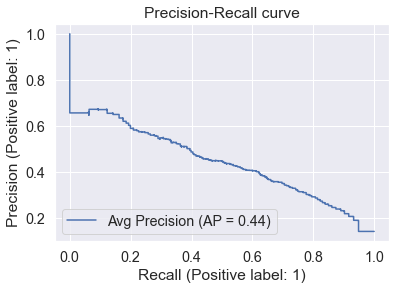

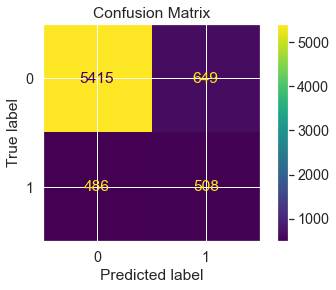

In [334]:
# rf_model = RandomForestClassifier(n_estimators=17, max_depth=8, bootstrap= False, random_state=42)
rf_model = RandomForestClassifier()


modelEval(rf_model)

# Deploy the model in backend server (accessible via a REST API)

# Make competition submission

In [239]:
data = test.drop(columns = ["uniqueid"])

In [241]:
# Scale numerical features if they exist in dataset
data[numerical] = input_scaler.fit_transform(data[numerical])

# Encode the categorical features(columns) and generate appropriate column names
cat_df = pd.DataFrame(cat_encoder.fit_transform(data[categorical]), index=data.index)

cat_df.columns = cat_encoder.get_feature_names_out(categorical)

# Join the new dataframe to our original data then drop the categorical columns
data = data.join(cat_df).drop(columns = categorical)

In [320]:
# model = LogisticRegression(random_state=42)
# model = RandomForestClassifier(random_state=42)
model = XGBClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(data)

[13:28:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [321]:
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [322]:
# sample_sub.sample()

In [323]:
d = {'unique_id': test["uniqueid"] + " x " + test["country"], 'bank_account': y_pred}

In [324]:
submission = pd.DataFrame(data = d)

In [325]:
# submission.to_csv('LR_sub.csv', index= False)
# submission.to_csv('RF_sub.csv', index= False)
submission.to_csv('XGB_sub.csv', index= False)

In [312]:
# test[(test['uniqueid'] == 'uniqueid_8103') & (test['country'] == 'Kenya')]